# 项目设想<br>
<font size=4>

1. 使用目标检测和人体关键点检测获得杠铃轨迹和单侧下肢关节的位置
2. 计算各个时刻膝关节髋关节的角度和力臂
3. 辅助观察是否存在不良力臂

In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data103531


In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

001.mp4  dataset  mp4_img  output


In [ ]:
#解压目标检测数据集
!unzip -oq /home/aistudio/data/data103531/DatasetId_215201_1628403652.zip -d squat_detect

In [ ]:
# 准备一些可能用到的工具库
import xml.etree.cElementTree as ET
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import paddle.fluid as fluid
import time
import random

In [ ]:
# 导入paddlex
!pip install paddlex

In [ ]:
# 使用paddlex进行数据集的划分训练集、验证集、测试集.
# 在此之前请将squat_detect/DatasetId_215201_1628403652/下的images文件夹改为JPEGImages
!paddlex --split_dataset --format VOC --dataset_dir squat_detect/DatasetId_215201_1628403652 --val_value 0.2 --test_value 0.01

Dataset Split Done.
Train samples: 284
Eval samples: 71
Test samples: 3
Split files saved in squat_detect/DatasetId_215201_1628403652


In [ ]:
#将数据集转到work/dataset/，专门存放和处理数据集的文件
!cp -r squat_detect/DatasetId_215201_1628403652 work/dataset/

In [ ]:
# 调整下标注文件命名，与默认的一致（处理成相同文件名）
#labels.txt改名为label_list.txt
!mv work/dataset/labels.txt work/dataset/label_list.txt

# 用paddleX训练一个杠铃片的目标检测模型

## <font size=4> **设置transform**

In [ ]:
import paddlex as pdx
from paddlex.det import transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(),
    transforms.ResizeByShort(short_size=800, max_size=1333),
    transforms.Padding(coarsest_stride=32)
])

eval_transforms = transforms.Compose([
    transforms.Normalize(),
    transforms.ResizeByShort(short_size=800, max_size=1333),
    transforms.Padding(coarsest_stride=32),
])

## <font size=4>**读数据**


In [ ]:
train_dataset = pdx.datasets.VOCDetection(
    data_dir='work/dataset/',
    file_list='work/dataset/train_list.txt',
    label_list='work/dataset/label_list.txt',
    transforms=train_transforms,
    shuffle=True)
eval_dataset = pdx.datasets.VOCDetection(
    data_dir='work/dataset/',
    file_list='work/dataset/val_list.txt',
    label_list='work/dataset/label_list.txt',
    transforms=eval_transforms)

2021-08-13 17:45:24 [INFO]	Starting to read file list from dataset...
2021-08-13 17:45:25 [INFO]	284 samples in file work/dataset/train_list.txt
creating index...
index created!
2021-08-13 17:45:25 [INFO]	Starting to read file list from dataset...
2021-08-13 17:45:25 [INFO]	71 samples in file work/dataset/val_list.txt
creating index...
index created!


## <font size=4>**训练**

In [ ]:
num_classes = len(train_dataset.labels)
model = pdx.det.YOLOv3(num_classes=num_classes, backbone='MobileNetV1')
model.train(
    num_epochs=70,
    train_dataset=train_dataset,
    train_batch_size=8,
    eval_dataset=eval_dataset,
    learning_rate=0.000125,
    lr_decay_epochs=[210, 240],
    save_interval_epochs=20,
    save_dir='work/output/yolov3_MobileNetV1',
    use_vdl=True)

<font size=4>**看看结果如何**

In [ ]:
import paddlex as pdx
model = pdx.load_model('work/output/yolov3_MobileNetV1/best_model')
image_name='work/mp4_img/145.jpg'#要处理的图片
result = model.predict(image_name)

pdx.det.visualize(image_name, result, threshold=0.1, save_dir='./')#可以调整阈值

2021-08-14 19:19:51 [INFO]	Model[YOLOv3] loaded.
2021-08-14 19:19:53 [INFO]	The visualized result is saved as ./visualize_145.jpg


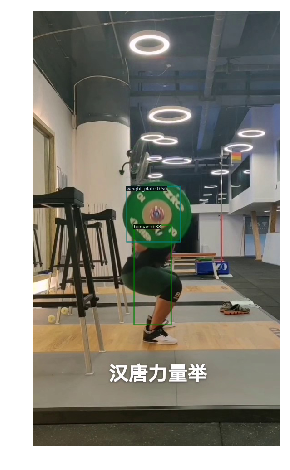

In [ ]:
from matplotlib.image import imread
import matplotlib.pyplot as plt

def show_img(img_path, size=8):

    im = imread(img_path)
    plt.figure(figsize=(size,size))
    plt.axis("off")
    plt.imshow(im)

#查看刚才的图片
show_img('visualize_145.jpg')

 **哎先凑合着用吧**

# 获得杠铃片中点的坐标

In [ ]:
import paddlex as pdx
import math

model = pdx.load_model('work/output/yolov3_MobileNetV1/best_model')

def get_wp(image_name, model):
    
    result = model.predict(image_name)
    #print(result)
    '''
    筛选出score最大的weight_plate的bbox坐标
    '''
    weight_plate_box = []
    for i in range(len(result)):
        if result[i]['category']=='weight_plate':
            weight_plate_box.append(result[i])
    #print(weight_plate_box)

    max_ = weight_plate_box[0]['bbox']
    for k in range(len(weight_plate_box)-1):
        if weight_plate_box[k]['score'] < weight_plate_box[k+1]['score']:
            max_ = weight_plate_box[k+1]['bbox']
    #print(max_)

    weight_plate = [math.ceil((max_[0]+max_[2])/2), math.ceil((max_[1]+max_[3])/2)]
    return weight_plate

get_wp(image_name='squat_detect/DatasetId_215201_1628403652/JPEGImages/110.jpeg', model=model)

2021-08-13 18:44:25 [INFO]	Model[YOLOv3] loaded.


[185, 226]

## **也可以试一试纯特征工程的模板匹配法**

top_left= (237, 440) bottom_right= (309, 511)


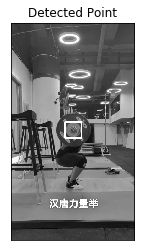

[273, 476]

In [21]:
import cv2
from matplotlib import pyplot as plt
import math

def track(img_, template_, is_show=False):

    img=cv2.imread(img_,0)
    template=cv2.imread(template_,0)

    w, h = template.shape[::-1]
    methods = 'cv2.TM_SQDIFF_NORMED'
    method = eval(methods)
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res) #找到最大值和最小值
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(img,top_left, bottom_right, 255, 5)

    if is_show==True:
        print('top_left=', top_left, 'bottom_right=', bottom_right)
        plt.subplot(122),plt.imshow(img,cmap = 'gray')
        plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
        plt.show()
    
    return [math.ceil(top_left[0]/2+bottom_right[0]/2), math.ceil(top_left[1]/2+bottom_right[1]/2)]

track(img_='work/mp4_img/150.jpg', template_='./muban.png', is_show=True)

# 人体关键点检测

**安装PaddleHub**

In [ ]:
!pip install paddlehub==2.0.0b1 -i https://pypi.tuna.tsinghua.edu.cn/simple

In [ ]:
import cv2
import os
import paddlehub as hub
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
%matplotlib inline

## 将视频中每一帧保存成图片

In [ ]:
def transform_video_to_image(video_file_path, img_path):
    '''
    将视频中每一帧保存成图片
    '''
    video_capture = cv2.VideoCapture(video_file_path)
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    count = 0
    while(True):
        ret, frame = video_capture.read() 
        if ret:
            cv2.imwrite(img_path + '%d.jpg' % count, frame)
            count += 1
        else:
            break
    video_capture.release()
    print('视频图片保存成功, 共有 %d 张' % count)
    return fps

In [ ]:
%cd work/
!mkdir mp4_img
%cd ..

/home/aistudio/work
/home/aistudio


In [ ]:
# 素材视频位置
input_video = 'work/001.mp4'

# 将视频中每一帧保存成图片
fps = transform_video_to_image(input_video, 'work/mp4_img/')

视频图片保存成功, 共有 720 张


## **遍历work/mp4_img 获得人体关键点**
<font size=4> 
  
* **paddlex + paddlehub**    时间长，忍一下
* **模板匹配 + paddlehub**

二选一即可

In [ ]:
'''
方法一：paddlex + paddlehub
'''
import paddlehub as hub
pose_estimation = hub.Module(name="human_pose_estimation_resnet50_mpii")
model = pdx.load_model('work/output/yolov3_MobileNetV1/best_model')

def get_keypoints(input_frame_path, output_frame_path, model_):
    keypoints = []
    file_items = os.listdir(input_frame_path)
    '''
    按照时间顺序遍历
    '''
    for i in range(len(file_items)):
        Path=[os.path.join(input_frame_path, str(i)+'.jpg')]
        print(Path)
        weight_plate = get_wp(image_name=Path[0], model=model_)
        result = pose_estimation.keypoint_detection(paths=Path,visualization=False)
        #result = pose_estimation.keypoint_detection(paths=Path,visualization=False, output_dir=output_frame_path) #输出可视化图片将保存在'work/pose_img/'
        
        keypoints.append([result[0]['data']['left_hip'][0], result[0]['data']['left_hip'][1],#记录髋的坐标
                        result[0]['data']['left_knee'][0], result[0]['data']['left_knee'][1],#记录膝的坐标
                        result[0]['data']['left_ankle'][0], result[0]['data']['left_ankle'][1],#记录踝的坐标
                        weight_plate[0], weight_plate[1]])#记录杠铃中心的坐标
        
    return keypoints

key_points = get_keypoints(input_frame_path='work/mp4_img/', output_frame_path='work/pose_img/', model_=model)

'''
写入csv，为防止代码执行器自动重启，导致key_points丢失
'''
import csv

with open('./key_points.csv', 'w', newline='') as csvfile:
    writer  = csv.writer(csvfile)
    for row in key_points:
        writer.writerow(row)


In [43]:
'''
方法二：模板匹配 + paddlehub
'''
import os
import paddlehub as hub
pose_estimation = hub.Module(name="human_pose_estimation_resnet50_mpii")

def get_keypoints(input_frame_path, output_frame_path):
    keypoints = []
    file_items = os.listdir(input_frame_path)
    '''
    按照时间顺序遍历
    '''
    for i in range(len(file_items)):
        Path=[os.path.join(input_frame_path, str(i)+'.jpg')]
        print(Path)
        weight_plate = track(img_=Path[0], template_='./muban.png')
        result = pose_estimation.keypoint_detection(paths=Path,visualization=False)
        #result = pose_estimation.keypoint_detection(paths=Path,visualization=False, output_dir=output_frame_path) #输出可视化图片将保存在'work/pose_img/'
        
        keypoints.append([result[0]['data']['left_hip'][0], result[0]['data']['left_hip'][1],#记录髋的坐标
                        result[0]['data']['left_knee'][0], result[0]['data']['left_knee'][1],#记录膝的坐标
                        result[0]['data']['left_ankle'][0], result[0]['data']['left_ankle'][1],#记录踝的坐标
                        weight_plate[0], weight_plate[1]])#记录杠铃中心的坐标
        
    return keypoints

key_points = get_keypoints(input_frame_path='work/mp4_img/', output_frame_path='work/pose_img/')

import csv #写入csv
with open('./key_points.csv', 'w', newline='') as csvfile:
    writer  = csv.writer(csvfile)
    for row in key_points:
        writer.writerow(row)

<font size=4>**再™从csv读出来**

In [44]:
import csv
with open("key_points.csv") as f:
    reader = csv.reader(f)
    key_points=[row for row in  reader]
    for i in range(len(key_points)):
        for j in range(8):
            key_points[i][j] = int(key_points[i][j])
            
print(key_points[2])

[272, 480, 311, 600, 266, 710, 286, 418]


<font size=4>**计算膝关节角度**

In [45]:
import math
import numpy as np

def get_knee_angle(key_points):
    knee_angle_list = []
    for i in key_points:
        '''
        通过向量算出膝角的cos值，再用反三角函数得到角度
        '''
        dot = (i[2]-i[0]) * (i[2]-i[4]) + (i[3]-i[1]) * (i[3]-i[5])
        m = math.sqrt(((i[2]-i[0])**2) + (i[3]-i[1])**2) * math.sqrt(((i[2]-i[4])**2) + (i[3]-i[5])**2)
        knee_angle = (180/math.pi) * np.arccos(dot/m)
        print(knee_angle)
        knee_angle_list.append(knee_angle)
    return knee_angle_list

y = get_knee_angle(key_points)
x = np.linspace(start=0, stop=len(y)+1, num=len(y))


len_x 720


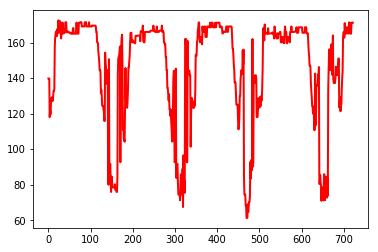

In [46]:
print("len_x",len(x))
import matplotlib.pyplot as plt
plt.plot(x,y,'r',label='knee_angle',linewidth=2,alpha=1)

<font size=4>**毛刺比较多，试试巴特沃斯低通滤波**

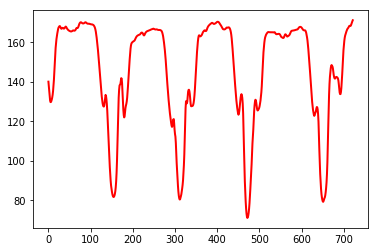

In [47]:
from scipy import signal

b, a = signal.butter(1, 0.1, 'lowpass')
filtedData1 = signal.filtfilt(b, a, y)

plt.plot(x,filtedData1,'r',label='knee_angle',linewidth=2, alpha=1)
#保存图片
plt.savefig("knee_angle.jpg")

 <font size=4> **计算膝关节角速度**

用后一帧减前一帧表示

720
721


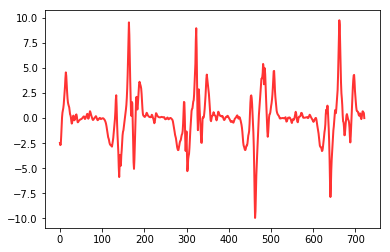

In [52]:
import copy

Y = copy.deepcopy(filtedData1.tolist())
Y.append(filtedData1[-1])
print(len(filtedData1))
print(len(Y))
'''
把角度y拷贝一份，在Y最后插一个y[-1]，避免相减导致长度不匹配
'''
angular_velocity = []

for i in range(len(filtedData1)):
    angular_velocity.append(Y[i+1] - Y[i])

#显示膝关节速度
plt.plot(x,angular_velocity,'r',label='angular_velocity',linewidth=2,alpha=0.8)

# 导出视频

## <font size=3> 先平滑所有点

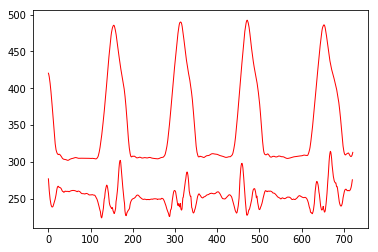

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
hip_x, hip_y, knee_x, knee_y, ankle_x, ankle_y, plate_x, plate_y= [],[],[],[],[],[],[],[]
for i in range(len(key_points)):
    hip_x.append(key_points[i][0])
    hip_y.append(key_points[i][1])
    knee_x.append(key_points[i][2])
    knee_y.append(key_points[i][3])
    ankle_x.append(key_points[i][4])
    ankle_y.append(key_points[i][5])
    plate_x.append(key_points[i][6])
    plate_y.append(key_points[i][7])

hip_x = signal.savgol_filter(hip_x,21,3)
hip_y = signal.savgol_filter(hip_y,21,3)
knee_x = signal.savgol_filter(knee_x,21,3)
knee_y = signal.savgol_filter(knee_y,21,3)
ankle_x = signal.savgol_filter(ankle_x,21,3)
ankle_y = signal.savgol_filter(ankle_y,21,3)
plate_x = signal.savgol_filter(plate_x,21,3)
plate_y = signal.savgol_filter(plate_y,21,3)

plt.plot(x, plate_y, 'r', label='knee_angle', linewidth=1, alpha=1)

x = np.linspace(start=0, stop=len(key_points), num=len(key_points))
plt.plot(x, hip_x, 'r', label='knee_angle', linewidth=1, alpha=1)

## <font size=3> 再绘制图片

In [60]:
!mkdir picture

In [61]:
import cv2
import numpy as np
from math import ceil

for i in range(len(key_points)):
    I=np.zeros((800,500),dtype=np.uint8)+255
    I=cv2.cvtColor(I,cv2.COLOR_GRAY2BGR)
    I = cv2.circle(I, (ceil(hip_x[i]), ceil(hip_y[i])), 8, (0,0,255), 0)#髋
    I = cv2.circle(I, (ceil(knee_x[i]), ceil(knee_y[i])), 8, (0,0,255), 0)#膝
    I = cv2.circle(I, (ceil(ankle_x[i]), ceil(ankle_y[i])), 8, (0,0,255), 0)#踝
    I = cv2.circle(I, (ceil(plate_x[i]), ceil(plate_y[i])), 8, (0,0,255), 0)#杠铃
    
    
    I = cv2.line(I,(ceil(hip_x[i]), ceil(hip_y[i])),(ceil(knee_x[i]), ceil(knee_y[i])), color=(255,0,0),thickness=5)
    I = cv2.line(I,(ceil(knee_x[i]), ceil(knee_y[i])),(ceil(ankle_x[i]), ceil(ankle_y[i])), color=(255,0,0),thickness=5)
    I = cv2.line(I,(ceil(hip_x[i]), ceil(hip_y[i])),(ceil(plate_x[i])+5, ceil(plate_y[i])+5), color=(255,0,0),thickness=5)
    # 从（）-》（）颜色（BGR 蓝）宽度是5

    cv2.imwrite('./picture/'+str(i)+'.jpg', I)

##  <font size=3> 最后图片合成视频

In [67]:
import cv2
import os

def combine_image_to_video(comb_path, output_file_path, fps=30, is_print=False):
    '''
        合并图像到视频
    '''
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')    
    
    file_items = os.listdir(comb_path)
    file_len = len(file_items)
    # print(comb_path, file_items)
    if file_len > 0 :
        temp_img = cv2.imread(os.path.join(comb_path, file_items[0]))
        img_height, img_width = temp_img.shape[0], temp_img.shape[1]
        
        out = cv2.VideoWriter(output_file_path, fourcc, fps, (img_width, img_height))

        for i in range(file_len):
            pic_name = os.path.join(comb_path, str(i)+".jpg")
            if is_print:
                print(i+1,'/', file_len, ' ', pic_name)
            img = cv2.imread(pic_name)
            out.write(img)
        out.release()

In [68]:
# 合并图像到视频
combine_image_to_video('picture/', 'output.mp4', fps=20)

# 总结与反思
<font size=5>
  
* 用paddleX做目标检测的效果其实不太理想，模板匹配要好一些。
* 由于场景里有圆形的灯，调试阶段还出现过下面的情况
  
<img src="https://ai-studio-static-online.cdn.bcebos.com/4749e41636674bc4a0de48caec98dbbcd01de6a69ae04d25895dac4a9a665ff1" height="660" width="380" >
  
* 场景比较简单，但可能是由于杠铃片遮挡了上肢，导致paddlehub对髋关节的检测不太理想。如果先检测杠铃片，在原图上拼接上半身，说不定会更好。

<img src="https://ai-studio-static-online.cdn.bcebos.com/4eb911aca78a4d4badf29b5c5ea0602cba3d39cf66264595b0ec8ed84d6359ac" height="330" width="190" >



请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 